# Uncertainy intervals

## Modeling uncertainty in trends

You may have noticed in different component plots throughout this book that the trend 
shows uncertainty bounds, while the seasonality curves do not. By default, Prophet only 
estimates uncertainty in the trend, plus uncertainty due to random noise in the data. 
The noise is modeled as a normal distribution around the trend and trend uncertainty is 
modeled with **maximum a posteriori (MAP) estimation**.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import numpy as np
np.random.seed(42)


In [3]:
URL = 'https://raw.githubusercontent.com/PacktPublishing/Forecasting-Time-Series-Data-with-Facebook-Prophet/main/data/baltimore_crime.csv'
df = pd.read_csv(URL)
df.columns = ['ds', 'y']

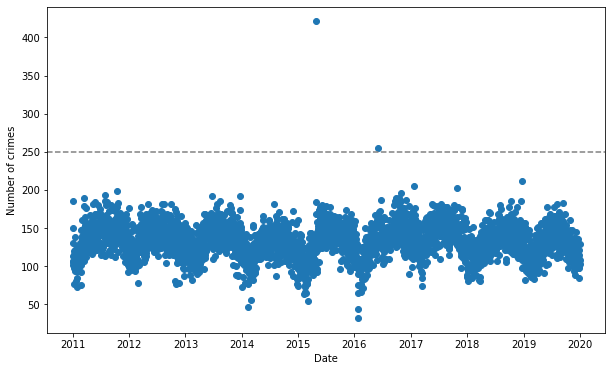

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(pd.to_datetime(df['ds']), df['y'])
plt.axhline(250, ls='--', c='gray')
plt.xlabel('Date')
plt.ylabel('Number of crimes')
plt.show()

In [5]:
df.loc[df['y'] > 250, 'y'] = None

The number of Monte Carlo simulations Prophet runs through is set with the 
`uncertainty_samples` argument during model instantiation. By default, it is set to 
`1000`, so Prophet simulates `1,000` different future trend lines and uses these to estimate 
uncertainty

In [6]:
model = Prophet(uncertainty_samples=1000)
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -48.3715
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6609.94   0.000159674       117.402   7.882e-07       0.001      158  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       6612.62    0.00040981        51.177   8.376e-06       0.001      276  LS failed, Hessian reset 
     199        6613.1    0.00082159       252.514           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6613.84    0.00015357       55.1822      0.6408      0.6408      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6614.57     0.0223975       260.527           1           1      582   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     410       6

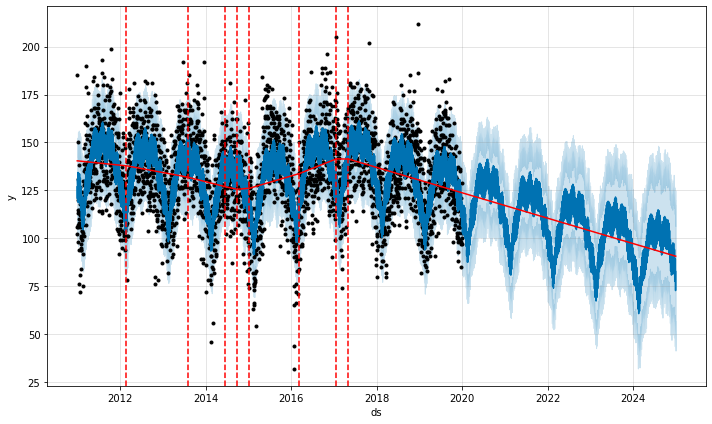

In [7]:
future = model.make_future_dataframe(periods=365 * 5)
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

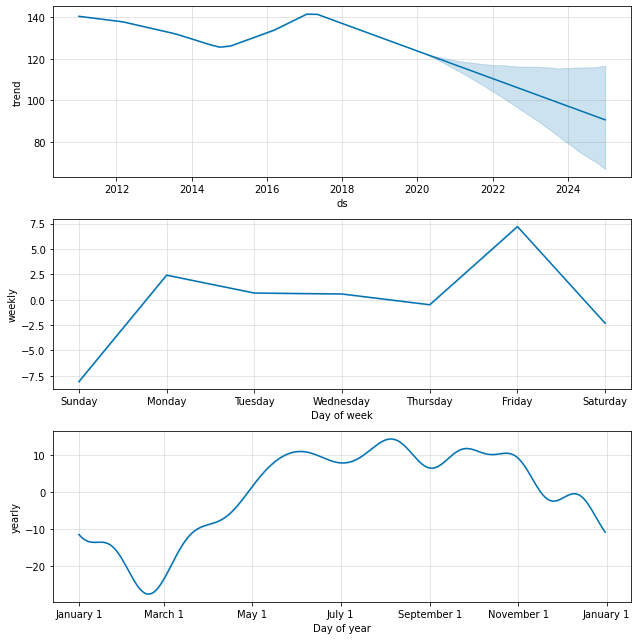

In [8]:
fig2 = model.plot_components(forecast)
plt.show()

In [9]:
# Saving for use later
m0 = model
f0 = forecast

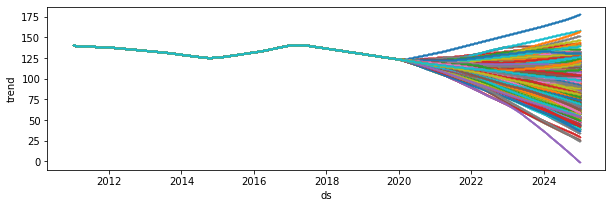

In [10]:
samples = model.predictive_samples(future)

plt.figure(figsize=(10, 3))
for idx in range(model.uncertainty_samples):
    plt.scatter(future['ds'], samples['trend'][:, idx], s=.1, alpha=1)
plt.xlabel('ds')
plt.ylabel('trend')
plt.show()

The uncertainty level can be controlled through the `interval_width` argument. If you 
want more confidence in your uncertainty levels, you may want to increase this value; 
decreasing it will give you tighter limits but less confidence.

In [11]:
model = Prophet(interval_width=0.99)
model.fit(df)
future = model.make_future_dataframe(periods=365 * 5)
forecast = model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -48.3715
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6609.94   0.000159674       117.402   7.882e-07       0.001      158  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       6612.62    0.00040981        51.177   8.376e-06       0.001      276  LS failed, Hessian reset 
     199        6613.1    0.00082159       252.514           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6613.84    0.00015357       55.1822      0.6408      0.6408      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6614.57     0.0223975       260.527           1           1      582   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     410       6

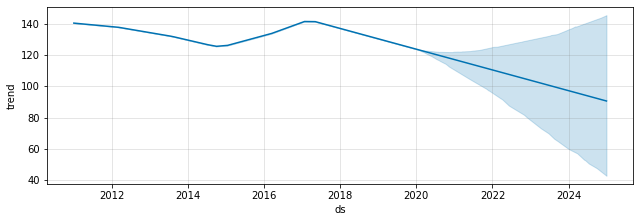

In [12]:
from prophet.plot import plot_forecast_component

plot_forecast_component(model,
                        forecast,
                        'trend',
                        figsize=(10.5, 3.25))
plt.show()

## Modeling uncertainty in seasonality

MAP estimation is very fast, which is why it is Prophet's default mode, but it will not work 
with seasonalities, so a different method is needed. To model seasonality uncertainty, 
Prophet needs to use an MCMC method. A **Markov chain** is a model that describes a 
sequence of events, with the probability of each event depending upon the state in the 
previous event. Prophet models seasonal uncertainty with this chained sequence and uses 
the Monte Carlo method, which was described at the beginning of the previous section, to 
repeat the sequence many times.

In [13]:
model = Prophet(mcmc_samples=300)
model.fit(df)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Gradient evaluation took 0.007239 seconds
1000 transitions using 10 leapfrog steps per transition would take 72.39 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.007808 seconds
1000 transitions using 10 leapfrog steps per transition would take 78.08 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.007898 seconds
1000 transitions using 10 leapfrog steps per transition would take 78.98 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.007455 seconds
1000 transitions using 10 leapfrog steps per transition would take 74.55 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:   1 / 300 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of th

Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 180 / 300 [ 60%]  (Sampling)
Iteration: 180 / 300 [ 60%]  (Sampling)


To run all diagnostics call pystan.check_hmc_diagnostics(fit)



 Elapsed Time: 141.745 seconds (Warm-up)
               159.814 seconds (Sampling)
               301.559 seconds (Total)



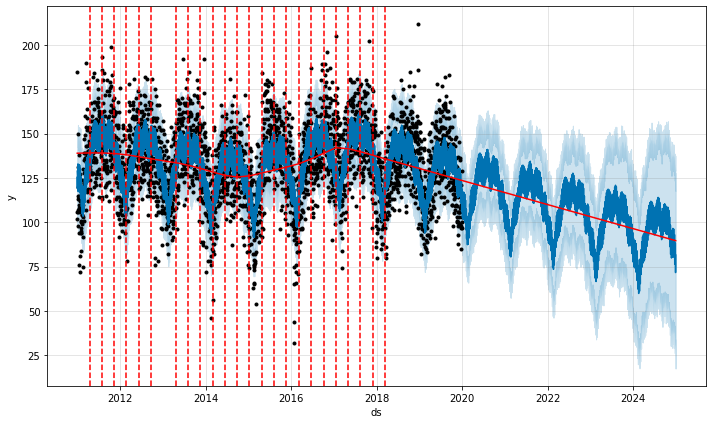

In [14]:
future = model.make_future_dataframe(periods=365 * 5)
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

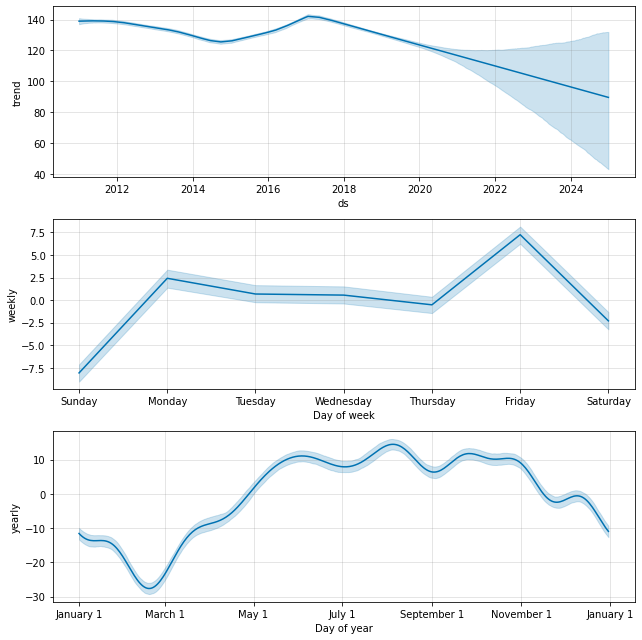

In [15]:
fig2 = model.plot_components(forecast)
plt.show()